In [ ]:
import tensorflow as tf
import tensorflow_hub as tf_hub

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow as tf

In [ ]:
logits = [3.0, 1.5, 0.2]
tf.nn.softmax(logits)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7788524 , 0.17378546, 0.04736206], dtype=float32)>

In [ ]:
print('TF Version:', tf.__version__)
print('TF Hub Version:', tf_hub.__version__)

TF Version: 2.3.0
TF Hub Version: 0.8.0


In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/\
data/ImageNetLabels.txt

--2020-09-22 17:06:51--  https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10484 (10K) [text/plain]
Saving to: ‘ImageNetLabels.txt.1’

ImageNetLabels.txt. 100%[===================>]  10.24K  --.-KB/s    in 0s      

2020-09-22 17:06:51 (108 MB/s) - ‘ImageNetLabels.txt.1’ saved [10484/10484]



In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
!wget https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt

data1k = []
with open('ImageNetLabels.txt', 'r') as f:
    data1k = f.readlines()

data21k = []
with open('imagenet21k_wordnet_lemmas.txt', 'r') as f:
    data21k = f.readlines()

imagenet1k_mapping = {i: value.strip('\n') 
                          for i, value in enumerate(data1k)}
imagenet21k_mapping = {i: value.strip('\n') 
                          for i, value in enumerate(data21k)}

--2020-08-16 00:56:29--  https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10484 (10K) [text/plain]
Saving to: ‘ImageNetLabels.txt’

ImageNetLabels.txt  100%[===================>]  10.24K  --.-KB/s    in 0s      

2020-08-16 00:56:29 (101 MB/s) - ‘ImageNetLabels.txt’ saved [10484/10484]

--2020-08-16 00:56:30--  https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522999 (511K) [text/plain]
Saving to: ‘imagenet2

In [ ]:
print('ImageNet 1K (ResNet-50) Total Classes:', 
      len(list(imagenet1k_mapping.items())))
print('Sample:', list(imagenet1k_mapping.items())[:5])

print('\nImageNet 21K (BiT ResNet-152 4x)Total Classes:', 
      len(list(imagenet21k_mapping.items())))
print('Sample:', list(imagenet21k_mapping.items())[:5])

ImageNet 1K (ResNet-50) Total Classes: 1001
Sample: [(0, 'background'), (1, 'tench'), (2, 'goldfish'), (3, 'great white shark'), (4, 'tiger shark')]

ImageNet 21K (BiT ResNet-152 4x)Total Classes: 21843
Sample [(0, 'organism, being'), (1, 'benthos'), (2, 'heterotroph'), (3, 'cell'), (4, 'person, individual, someone, somebody, mortal, soul')]


In [ ]:
resnet_model_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
resnet_50 = tf_hub.KerasLayer(resnet_model_url)

bit_model_url = "https://tfhub.dev/google/bit/m-r152x4/imagenet21k_classification/1"
bit_r152x4 = tf_hub.KerasLayer(bit_model_url)

In [ ]:

def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image

In [ ]:
def visualize_predictions(model, image, imagenet_mapping_dict, 
                          model_type='resnet'):
    if model_type =='resnet':
        probs = model(image)
        probs = tf.reshape(probs, [-1])
    else:
        logits = model(image)
        logits = tf.reshape(logits, [-1])
        probs = tf.nn.softmax(logits)
    top5_imagenet_idxs = np.argsort(probs)[:-6:-1]
    top5_probs = np.sort(probs)[:-6:-1]
    pred_labels = [imagenet_mapping_dict[i] 
                       for i in top5_imagenet_idxs]

    height = top5_probs
    bars = pred_labels
    y_pos = np.flip(np.arange(len(bars)))
    
    # Create horizontal bars
    plt.barh(y_pos, height, color='skyblue')
    for i, v in zip(y_pos, height):
        plt.text(x=max(0.05, v-0.3), y=i-0.15, 
                s=round(v,3), color='black', size=15)
    
    # Create names on the y-axis
    plt.yticks(y_pos, bars);
    plt.title('Model: '+model_type)

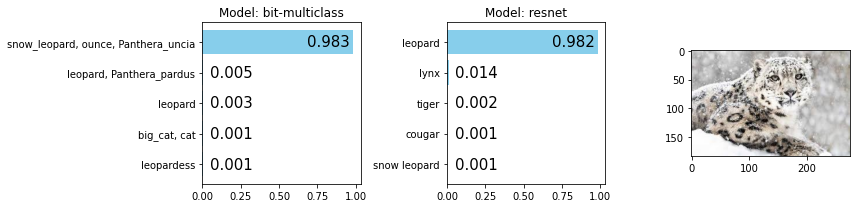

In [ ]:
img = Image.open('snow_leo.png').convert("RGB")
pre_img = preprocess_image(img)
plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
visualize_predictions(model=bit_r152x4, image=pre_img,
                      imagenet_mapping_dict=imagenet21k_mapping,
                      model_type='bit-multiclass')

plt.subplot(1,3,2)
resnet_img = tf.image.resize(pre_img, (224, 224))
visualize_predictions(model=resnet_50, image=resnet_img,
                      imagenet_mapping_dict=imagenet1k_mapping,
                      model_type='resnet')

plt.subplot(1,3,3)
plt.imshow(pre_img[0])
plt.tight_layout()

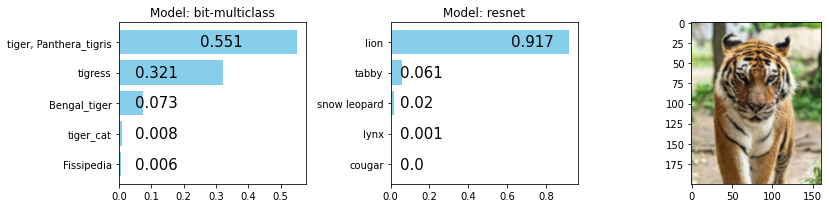

In [ ]:
img = Image.open('tiger.png').convert("RGB")
pre_img = preprocess_image(img)
plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
visualize_predictions(model=bit_r152x4, image=pre_img,
                      imagenet_mapping_dict=imagenet21k_mapping,
                      model_type='bit-multiclass')

plt.subplot(1,3,2)
resnet_img = tf.image.resize(pre_img, (224, 224))
visualize_predictions(model=resnet_50, image=resnet_img,
                      imagenet_mapping_dict=imagenet1k_mapping,
                      model_type='resnet')

plt.subplot(1,3,3)
plt.imshow(pre_img[0])
plt.tight_layout()

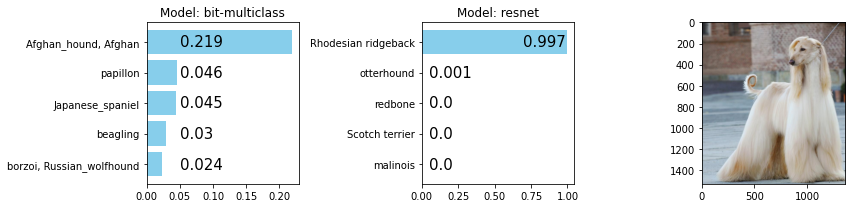

In [ ]:
img = Image.open('afghan_hound.png').convert("RGB")
pre_img = preprocess_image(img)
plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
visualize_predictions(model=bit_r152x4, image=pre_img,
                      imagenet_mapping_dict=imagenet21k_mapping,
                      model_type='bit-multiclass')

plt.subplot(1,3,2)
resnet_img = tf.image.resize(pre_img, (224, 224))
visualize_predictions(model=resnet_50, image=resnet_img,
                      imagenet_mapping_dict=imagenet1k_mapping,
                      model_type='resnet')

plt.subplot(1,3,3)
plt.imshow(pre_img[0])
plt.tight_layout()